### Load modules 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from numpy.linalg import solve

import pybobyqa
import pandas as pd

import cmcrameri as cmc

import cartopy
mollweide = cartopy.crs.Mollweide(central_longitude=0)
geodetic = cartopy.crs.Geodetic()

import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.linalg import circulant
from scipy import sparse

### Load data

'monthly_mean.npz' is too large to put in the repository. It is the collection of the daily surface air temperature on 192 latitudes and 288 longitudes from the atmospheric component in the 35 CESM-LENS runs performed at NCAR.

In [2]:
runsUsed = 6

data = np.load('monthly_mean.npz')

temp = data['temp'][:,:,:,:runsUsed]
lon = data['lon']
lat = data['lat']

T, M, N, R = temp.shape
# T: time points
# M: latitudes
# N: longitudes
# R: runs

data = np.load('../forcing.npz')
forcing = data['forcing']

year = forcing[:,0].astype('int')
forcing = forcing[:,1]

temp = temp.reshape(1140,-1,R) # flatten the lat and lon axes

NM = N * M # grid points
nHarmonics = 3

### Inference functions

In [3]:
def getK(phi):
    K = np.zeros((T,T))
    K[0,0] = 1
    for col in range(1,T):
        K[0,col] = phi * K[0,col-1]
    for row in range(1,T):
        K[row,row:] = K[row-1, row-1:-1]
    K = K + K.T
    K[range(T),range(T)] = 1

    return K

def getX(rho):
    X = np.ones((T,3 + 2*nHarmonics))
    
    # Calculate the past trajectory of forcing for year 2006
    _coef = 1
    _traj = 0;
    for year in range(239,-1,-1): # forcing[239] is the forcing for 2004
        _traj += _coef * forcing[year]
        _coef *= rho
    _traj *= (1-rho)
    
    for month in range(T):
        year = month//12
        _year = year+241 # 241 is the index for year 2006 in forcing
        
        X[month,1] = forcing[_year] 
        
        if month%12 == 0: # Jan
            _traj = (1-rho) * forcing[_year-1] + rho * _traj

        X[month,2] = _traj
        
    for harmonic in range(nHarmonics):
        X[:, harmonic+3]            = np.cos( 2*np.pi * np.arange(0,T) / 12 * (harmonic+1) )
        X[:, harmonic+3+nHarmonics] = np.sin( 2*np.pi * np.arange(0,T) / 12 * (harmonic+1) )
        
    return X

In [4]:
def neg_llh_step1(arg):    
    rho, phi = arg
    value = np.log(1-phi*phi) * runsUsed * (T-1)
    
    # Build K
    K = getK(phi)
    
    # Build X
    X = getX(rho)
    
    Y = temp[:,loc,:runsUsed]
    Kiy = np.linalg.solve(K, Y)

    part1 = np.sum(Y * Kiy, axis = 0)
    part2 = X.T @ Kiy
    part2 = np.sum(part2 * np.linalg.solve(X.T @ np.linalg.solve(K,X), part2), axis = 0)

    value += np.sum(T * np.log( (part1-part2)/T ))
        
    return value

In [5]:
def neg_llh_step2(arg):
    psi, alpha, nu = arg
    
    tmp = psi / np.power((alpha*alpha + 4*np.sin(omega/2)**2), nu+0.5)
                
    SigmaInv = circulant(np.real(np.fft.ifft(1/tmp))).T
    
    ldet = np.sum(np.log(tmp)) 
    
    Y = eta[:,:,latBand]
    value = np.sum( (Y @ SigmaInv) * Y )

    value += ldet * T * R
        
    return value

In [6]:
def get_marginal_power_spectral(psi, alpha, nu):
    return psi / np.power((alpha*alpha + 4*np.sin(omega/2)**2), nu+0.5)

def get_SigmaFactor(psi, alpha, nu):
    tmp = np.sqrt(psi / np.power((alpha*alpha + 4*np.sin(omega/2)**2), nu+0.5))
    SigmaFactor = np.outer(np.ones(N), tmp) * np.exp(1j * np.outer(np.arange(N), omega)) / np.sqrt(N)

    return SigmaFactor

def get_coherence(xi, kappa, latDiff):
    return np.power(xi / (1 + 4*np.sin(omega/2)**2)**kappa, np.abs(latDiff))

def neg_llh_step3(arg):
    Mlist = range(M)
    Msmall = len(Mlist)

    xi, kappa = arg

    # Compute log determinant
    tmp = get_coherence(xi, kappa, 1)
    ldet = T * R * (Msmall-1) * np.sum(np.log(1-tmp*tmp))

    value = 0
    for c in range(N//2+1):        
        Finv = np.zeros((Msmall,Msmall))
        Finv[range(Msmall),range(Msmall)] = 1
        Finv[range(1,Msmall-1),range(1,Msmall-1)] += tmp[c]*tmp[c] 
        Finv[range(1,Msmall),range(0,Msmall-1)] = -tmp[c]
        Finv[range(Msmall-1),range(1,Msmall)] = -tmp[c]
        Finv /= 1-tmp[c]*tmp[c]

        FinvSparse = sparse.csr_matrix(Finv)
        if c == 0 or c == N//2:
            value += np.sum(sparse.csc_matrix.dot(etaFFTstandardized[:,Mlist,c], FinvSparse) \
                                * etaFFTstandardized[:,Mlist,c])
        else:
            value += 2 * np.sum(sparse.csc_matrix.dot(etaFFTstandardized[:,Mlist,c], FinvSparse) \
                                * etaFFTstandardized[:,Mlist,c])
    value += ldet

    return value

### Model Inference, Step 1
The following inference takes a very long and acts as a prototype for illustration. We distributed the code to a cluster as run the jobs in parallel to get the estimates.

In [7]:
use_precomputed_results = True

In [8]:
if use_precomputed_results:
    data = np.load('results_model4_step1.npz') # The result file is too large to put in the repo
    eta = data['eta']
    beta = data['beta']
    sigma = data['sigma']
    rho = data['rho']
    phi = data['phi']
else:
    rho = np.zeros(NM)
    phi = np.zeros(NM)
    sigma = np.zeros(NM)
    beta = np.zeros((NM, 3 + nHarmonics * 2))
    eta = np.zeros((R,T,NM))
    for loc in range(NM):
        res = pybobyqa.solve(neg_llh_step1, x0 = [0.1, 0.9],
                 bounds = ([0.01, -0.99], [0.99, 0.99])
                )
        rho[loc], phi[loc] = res.x

        # Build K
        K = getK(phi[loc])

        # Build X
        X = getX(rho[loc])

        for r in range(runsUsed):
            _beta = solve(X.T @ solve(K, X), X.T @ solve(K, temp[:,loc,r]))

            beta[loc] += _beta

            _err = temp[:,loc,r] - X @ _beta
            sigma[loc] += solve(K, _err) @ (_err) / T

        beta[loc] /= runsUsed
        sigma[loc] = np.sqrt(sigma[loc]/runsUsed)

        mean = X @ beta[loc]
        epsilon = temp[:,loc].T - mean

        eta[:,0,loc] = epsilon[:,0]/sigma[loc]
        eta[:,1:,loc] = (epsilon[:,1:] -  epsilon[:,:-1]) / sigma[loc]

    np.savez('results_model4_step1.npz', 
             beta = beta, sigma = sigma, eta = eta, rho = rho, phi = phi)

rho = rho.reshape(M,N)
phi = phi.reshape(M,N)
sigma = sigma.reshape(M,N)
beta = beta.reshape(M,N,-1)
eta = eta.reshape(R,T,M,N)

## Model Inference, Step 2, Longitude dependence modeling for each latitude (Axially symmetric)

In [9]:
omega = 2*np.pi*np.arange(N)/N

if use_precomputed_results:
    data = np.load('results_model4_step2.npz') # The result file is too large to put in the repo
    psi = data['psi']
    alpha = data['alpha']
    nu = data['nu']
else:
    psi, alpha, nu = np.zeros(M), np.zeros(M), np.zeros(M)
    for latBand in range(M):
        res = pybobyqa.solve(neg_llh_step2, 
                             x0 = [0.05, 0.1, 0.5], 
                             bounds = ([1e-4, 1e-4, 1e-4], [1, 1, 10]),
                             maxfun = 10000,
                        )
        psi[latBand], alpha[latBand], nu[latBand] = res.x
    np.savez('results_model4_step2.npz', psi = psi, alpha = alpha, nu = nu)

### Plot

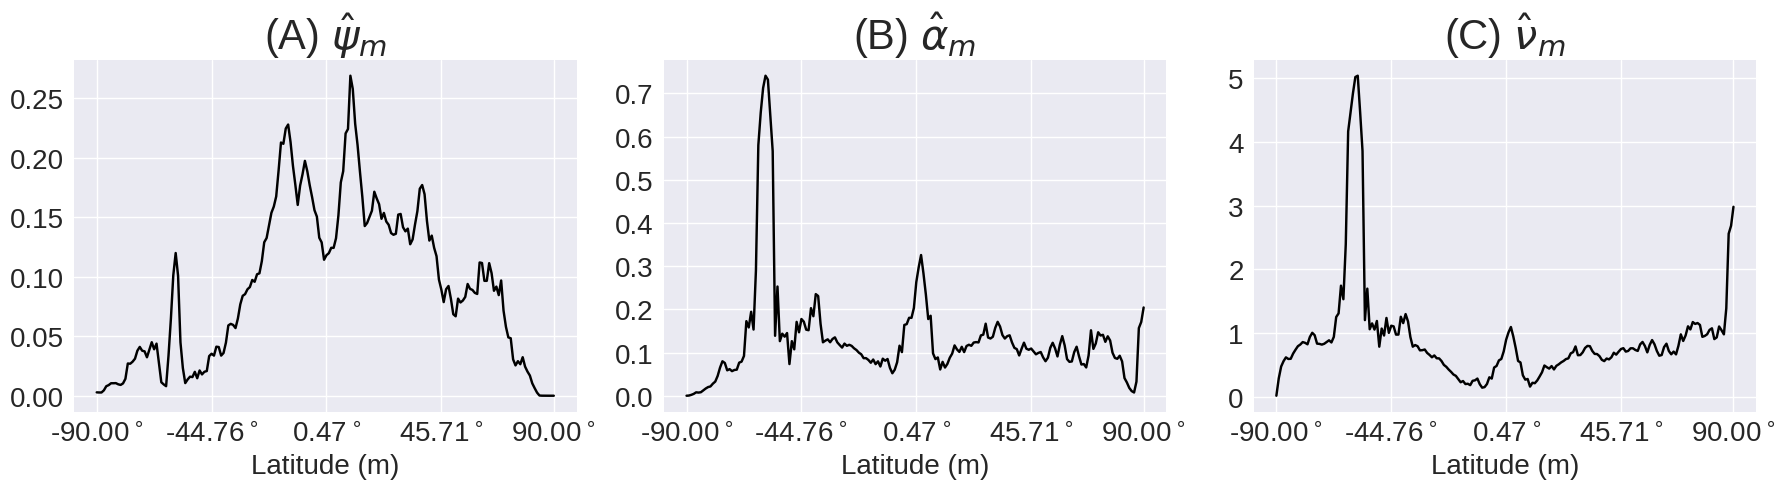

In [10]:
import matplotlib
matplotlib.style.use('seaborn')

plt.figure(figsize = (18,5))
plt.subplot(131)

plt.plot(psi, 'k')
plt.title(r'(A) $\hat\psi_m$', fontsize = 30)
plt.xlabel('Latitude (m)', fontsize = 20)
plt.xticks([*range(0,192,48),191], ['{:.2f}$^\circ$'.format(x) for x in lat[[*range(0,192,48),191]]], 
           fontsize = 20)
plt.yticks(fontsize = 20)

plt.subplot(132)

plt.plot(alpha, 'k')
plt.title(r'(B) $\hat\alpha_m$', fontsize = 30)
plt.xlabel('Latitude (m)', fontsize = 20)
plt.xticks([*range(0,192,48),191], ['{:.2f}$^\circ$'.format(x) for x in lat[[*range(0,192,48),191]]], 
           fontsize = 20)
plt.yticks(fontsize = 20)

plt.subplot(133)

plt.plot(nu, 'k')
plt.title(r'(C) $\hat\nu_m$', fontsize = 30)
# plt.ylabel(r'', fontsize = 30)
plt.xlabel('Latitude (m)', fontsize = 20)
plt.xticks([*range(0,192,48),191], ['{:.2f}$^\circ$'.format(x) for x in lat[[*range(0,192,48),191]]], 
           fontsize = 20)
plt.yticks(fontsize = 20)

plt.tight_layout()

plt.savefig('SF10-grid-lon-par.pdf', bbox_inches = 'tight')

## Model Inference, Step 3, Latitude dependence modeling for each latitude

In [11]:
if use_precomputed_results:
    data = np.load('results_model4_step3.npz')
    xi = data['xi']
    kappa = data['kappa']
else:
    etaFFTstandardized = np.zeros((N,M,T*R))
    for m in range(M):
        SigmaFactor = get_SigmaFactor(psi[m], alpha[m], nu[m])
        etaFFTstandardized[:,m] = np.real(np.linalg.solve(SigmaFactor,eta[:,:,m,:].T.reshape(N,-1)))

    etaFFTstandardized = etaFFTstandardized.T  # dim: T*R, M, N

    res = pybobyqa.solve(neg_llh_step3, 
                         x0 = [0.99, 0.5], 
                         bounds = ([0.01, 0.00001], [0.99999, 100]),
                         print_progress=False,
                         maxfun = 10000,
                    )
    xi, kappa = res.x
    
    np.savez('results_model4_step3.npz',
             xi = xi, kappa = kappa)

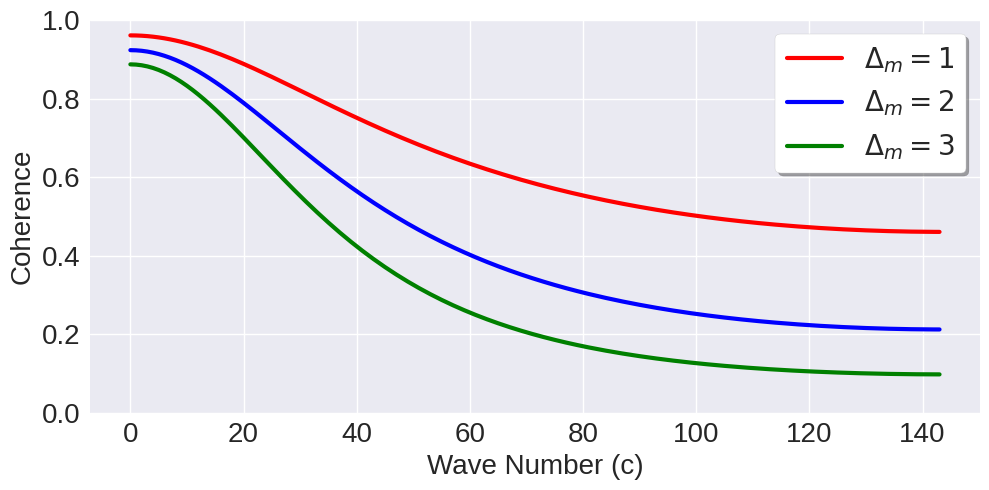

In [12]:
import matplotlib
matplotlib.style.use('seaborn')
plt.figure(figsize = (10,5))

plt.plot(get_coherence(xi, kappa, 1)[:int(N//2)], color = 'red',
         label = f'$\Delta_m=1$', linewidth = 3)

plt.plot(get_coherence(xi, kappa, 2)[:int(N//2)], color = 'blue',
         label = f'$\Delta_m=2$', linewidth = 3)

plt.plot(get_coherence(xi, kappa, 3)[:int(N//2)], color = 'green',
         label = f'$\Delta_m=3$', linewidth = 3)


plt.xlabel('Wave Number (c)', fontsize = 20)
plt.ylabel('Coherence', fontsize = 20)

plt.ylim(0,1)

plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)

plt.legend(fontsize = 20, frameon = True, facecolor = 'white', 
                 shadow = True, fancybox = True)

plt.tight_layout()

plt.savefig('SF11-grid-coherence.pdf', bbox_inches = 'tight')